# CFPB Customer Complait Issue

## Feature Engineering

### 1. Import Packages

In [34]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Basic operations
import numpy as np
import pandas as pd

# Visualizations
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

#
from datetime import *
import math


### 2. Load data

In [2]:
data = pd.read_csv('./cleaned_1.csv')
data.shape

(860606, 12)

In [8]:
data.head(3)

,Date_received,Product,Issue,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Is_Timely_response,Is_Consumer_disputed,Complaint_ID,days_spend,year,month,mean_rate_by_time,mean_rate_over_avg_by_time
0,2014-03-12,Mortgage,"Loan modification,collection,foreclosure",M&T BANK CORPORATION,MI,48382,Referral,2014-03-17,Closed with explanation,1,No,759217,5.0,2014,3,0.984378,0.011944
1,2014-03-04,Mortgage,"Loan servicing, payments, escrow account",OCWEN LOAN SERVICING LLC,NJ,07724,Web,2014-03-04,Closed with explanation,1,No,743072,0.0,2014,3,0.984378,0.011944
2,2014-03-03,Debt collection,Cont'd attempts collect debt not owed,"International Computer Systems, Inc.",OH,44035,Web,2014-03-03,Closed with explanation,1,No,739560,0.0,2014,3,0.984378,0.011944


### 3. Feature Engineering

In [4]:
def mean_rate_by_cat(data, cat):
    cat = str(cat)
    
    # Calculate mean response rate of each cat
    mean_rate_by_cat = data.groupby('%s'%cat).mean()
    
    # reset index
    mean_rate_by_cat['%s'%cat] = mean_rate_by_cat.index
    mean_rate_by_cat.columns = ['mean_response_rate_by_%s'%cat, '%s'%cat]
    mean_rate_by_cat = mean_rate_by_cat.reset_index(drop=True)
    
    # Calculate mean response rate of each cat
    mean_rate_by_cat['mean_response_rate_over_avg_by_%s'%cat] = mean_rate_by_cat['mean_response_rate_by_%s'%cat] / 0.972434 - 1

    return mean_rate_by_cat

In [5]:
def freq_by_cat(data, cat):
    cat = str(cat)
    # Calculate the frequency of each cat
    freq = data.groupby('%s'%cat).count()/860606
    # reset index
    freq['%s'%cat] = freq.index
    freq.columns = ['freq_by_%s'%cat, '%s'%cat]
    freq = freq.reset_index(drop=True)
    
    return freq

** Time **

In [9]:
# Time 
data.Date_received = pd.to_datetime(data.Date_received)
data.Date_sent_to_company = pd.to_datetime(data.Date_sent_to_company)

# Using np array in order to calcalate quicker
rece = np.array(data.Date_received)
sent = np.array(data.Date_sent_to_company)
days = (sent - rece).astype('timedelta64[D]') / np.timedelta64(1, 'D')

# New feature: days_spend
data['days_spend'] = days

# New features: year and month
data['year'] = data.Date_received.dt.year
data['month'] = data.Date_received.dt.month

In [7]:
time = data[['year','month','Is_Timely_response']]

# Calculate mean response rate by month and year
mean_rate_by_time = time.groupby(['year','month']).mean()
mean_rate_by_time.columns = ['mean_rate_by_time']

# reset index
mean_rate_by_time = mean_rate_by_time.reset_index(level=['year', 'month'])
mean_rate_by_time['mean_rate_over_avg_by_time'] = mean_rate_by_time.mean_rate_by_time - 0.972434

# Two new features: mean_rate_over_avg_by_time, mean_rate_by_time
data = pd.merge(data, mean_rate_by_time, on=['year','month'])

** Company **

In [10]:
# Extract Company 
company = data[['Company', 'Is_Timely_response']]
company = company.groupby('Company').count()
company = company.sort('Is_Timely_response', ascending=False)
company.columns = ['complaint_count']

# Scale Company based on number of complaints
scale1 = company[company.complaint_count<=10].index
scale10 = company[(company.complaint_count<=100) & (company.complaint_count>10)].index
scale100 = company[(company.complaint_count<=1000) & (company.complaint_count>100)].index
scale1000 = company[(company.complaint_count<=10000) & (company.complaint_count>1000)].index
scale10000 = company[company.complaint_count>10000].index

# Encode number of complaints
s1 = pd.DataFrame(index=scale1,data=np.ones(len(scale1)))
s10 = pd.DataFrame(index=scale10,data=2*np.ones(len(scale10)))
s100 = pd.DataFrame(index=scale100,data=3*np.ones(len(scale100)))
s1000 = pd.DataFrame(index=scale1000,data=4*np.ones(len(scale1000)))
s10000 = pd.DataFrame(index=scale10000,data=5*np.ones(len(scale10000)))

# Create complaint_scale data frame 
scale = pd.concat([s1,s10,s100,s1000,s10000])
scale.columns = ['complaint_scale']
scale['Company'] = scale.index

# New feature: complaint_scale
data = pd.merge(data, scale, on='Company')

In [11]:
company = data[['Company', 'Is_Timely_response']]

mean_rate_by_company = mean_rate_by_cat(company, 'Company')
freq_by_company = freq_by_cat(company, 'Company')

# Two new features: mean_response_rate_by_company, mean_rate_over_avg_by_company
data = pd.merge(data, mean_rate_by_company, on='Company')
# One new feature: freq_by_company
data = pd.merge(data, freq_by_company, on='Company')

** Is_Consumer_disputed **

In [12]:
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'Yes'] = 1
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'No'] = 0
data.Is_Consumer_disputed[data.Is_Consumer_disputed == 'NotKnow'] = -1

In [13]:
Is_Consumer_disputed = data[['Is_Consumer_disputed', 'Is_Timely_response']]

mean_rate_by_disput = mean_rate_by_cat(Is_Consumer_disputed, 'Is_Consumer_disputed')
freq_by_disput = freq_by_cat(Is_Consumer_disputed, 'Is_Consumer_disputed')

# Two new features: mean_response_rate_by_issue, mean_rate_over_avg_by_issue
data = pd.merge(data, mean_rate_by_disput, on='Is_Consumer_disputed')
# One new feature: freq_by_issue
data = pd.merge(data, freq_by_disput, on='Is_Consumer_disputed')

** Issue **

In [14]:
issue = data[['Issue', 'Is_Timely_response']]

In [15]:
mean_rate_by_issue = mean_rate_by_cat(issue, 'Issue')
freq_by_issue = freq_by_cat(issue, 'Issue')

# Two new features: mean_response_rate_by_issue, mean_rate_over_avg_by_issue
data = pd.merge(data, mean_rate_by_issue, on='Issue')
# One new feature: freq_by_issue
data = pd.merge(data, freq_by_issue, on='Issue')

In [16]:
'''
issue.str.contains(
    'Loan|loan|Debt|debt|credit|Credit|Lender|lender|broker'
).sum()

issue.str.contains(
    'Problem|problem|report|Report|info|Information|information|advertising|Advertising|Other'
).sum()

issue.str.contains(
    'Account|account|Lost|stolen|missing|statements|Billing|cash|withdrawals|card|Property|property|Deposite|Communication|Overdraft|overdraft|vehicle|Vehicle'
).sum()

'''

"\nissue.str.contains(\n    'Loan|loan|Debt|debt|credit|Credit|Lender|lender|broker'\n).sum()\n\nissue.str.contains(\n    'Problem|problem|report|Report|info|Information|information|advertising|Advertising|Other'\n).sum()\n\nissue.str.contains(\n    'Account|account|Lost|stolen|missing|statements|Billing|cash|withdrawals|card|Property|property|Deposite|Communication|Overdraft|overdraft|vehicle|Vehicle'\n).sum()\n\n"

** Product **

In [17]:
product = data[['Product', 'Is_Timely_response']]

In [18]:
mean_rate_by_product = mean_rate_by_cat(product, 'Product')
freq_by_product = freq_by_cat(product, 'Product')

# Two new features: mean_response_rate_by_product, mean_rate_over_avg_by_product
data = pd.merge(data, mean_rate_by_product, on='Product')
# One new feature: freq_by_product
data = pd.merge(data, freq_by_product, on='Product')

** State **

In [19]:
State = data[['State', 'Is_Timely_response']]

In [20]:
mean_rate_by_State = mean_rate_by_cat(State, 'State')
freq_by_State = freq_by_cat(State, 'State')

# Two new features: mean_response_rate_by_product, mean_rate_over_avg_by_product
data = pd.merge(data, mean_rate_by_State, on='State')
# One new feature: freq_by_product
data = pd.merge(data, freq_by_State, on='State')

** ZIP_Code **

In [21]:
ZIP_code = data[['ZIP_code', 'Is_Timely_response']]

In [22]:
mean_rate_by_ZIP_code = mean_rate_by_cat(ZIP_code, 'ZIP_code')
freq_by_ZIP_code = freq_by_cat(ZIP_code, 'ZIP_code')

# Two new features: mean_response_rate_by_product, mean_rate_over_avg_by_product
data = pd.merge(data, mean_rate_by_ZIP_code, on='ZIP_code')
# One new feature: freq_by_product
data = pd.merge(data, freq_by_ZIP_code, on='ZIP_code')

** One-hot encoding **

In [1]:
data1=data.copy()

NameError: name 'data' is not defined

In [25]:
data1.head(2)

,Date_received,Product,Issue,Company,State,ZIP_code,Submitted_via,Date_sent_to_company,Company_response_to_consumer,Is_Timely_response,...,freq_by_Issue,mean_response_rate_by_Product,mean_response_rate_over_avg_by_Product,freq_by_Product,mean_response_rate_by_State,mean_response_rate_over_avg_by_State,freq_by_State,mean_response_rate_by_ZIP_code,mean_response_rate_over_avg_by_ZIP_code,freq_by_ZIP_code
0,2014-03-12,Mortgage,"Loan modification,collection,foreclosure",M&T BANK CORPORATION,MI,48382,Referral,2014-03-17,Closed with explanation,1,...,0.129546,0.97933,0.007092,0.274616,0.976779,0.004468,0.02487,0.983923,0.011815,0.001084
1,2014-06-13,Mortgage,"Loan modification,collection,foreclosure",M&T BANK CORPORATION,MI,48382,Fax,2014-06-17,Closed with explanation,1,...,0.129546,0.97933,0.007092,0.274616,0.976779,0.004468,0.02487,0.983923,0.011815,0.001084


In [26]:
dummies = pd.get_dummies(data1[[1,2,4,6]])

In [27]:
data1 = data1.drop(
    ['Date_received', 'ZIP_code', 'Date_sent_to_company', 
     'Complaint_ID', 'Company', 'Product', 'Issue', 'State', 
     'Submitted_via', 'Company_response_to_consumer'], 1
)

In [28]:
data1 = pd.concat([data1,dummies],1,join='inner')
data1.head(2)

,Is_Timely_response,Is_Consumer_disputed,days_spend,year,month,mean_rate_by_time,mean_rate_over_avg_by_time,complaint_scale,mean_response_rate_by_Company,mean_response_rate_over_avg_by_Company,...,State_WA,State_WI,State_WV,State_WY,Submitted_via_Email,Submitted_via_Fax,Submitted_via_Phone,Submitted_via_Postal mail,Submitted_via_Referral,Submitted_via_Web
0,1,0,5.0,2014,3,0.984378,0.011944,4.0,0.987044,0.015024,...,0,0,0,0,0,0,0,0,1,0
1,1,0,4.0,2014,6,0.978667,0.006233,4.0,0.987044,0.015024,...,0,0,0,0,0,1,0,0,0,0


** Outliers in days_spend **

In [36]:
avg = data1.days_spend.mean()

In [37]:
avg + 3 * math.sqrt(data1.days_spend.var())

53.7107784586878

In [50]:
data1.Is_Timely_response[data1.days_spend > 53].mean()

0.9309626156050541

In [29]:
data1.to_csv('./data_for_tree.csv', index=False)
data1.shape

(860606, 278)

### 4. Feature Selection / Reduction

In [59]:
import xgboost as xgb

/Users/yangtian/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [95]:
data1.shape

(860606, 289)

In [96]:
data1.Is_Consumer_disputed = data1.Is_Consumer_disputed.astype('int')

In [97]:
label = data1.Is_Timely_response
del data1['Is_Timely_response']

In [98]:
dtrain = xgb.DMatrix(data1, label=label)

In [100]:
param = {'max_depth': 20, 'eta': 100, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = ['auc', 'ams@0']

In [69]:
import time

In [101]:
start_time = time.time()

num_round = 300
bst = xgb.train(param, dtrain, num_round)

print("--- %s seconds ---" % (time.time() - start_time))

--- 622.9971420764923 seconds ---


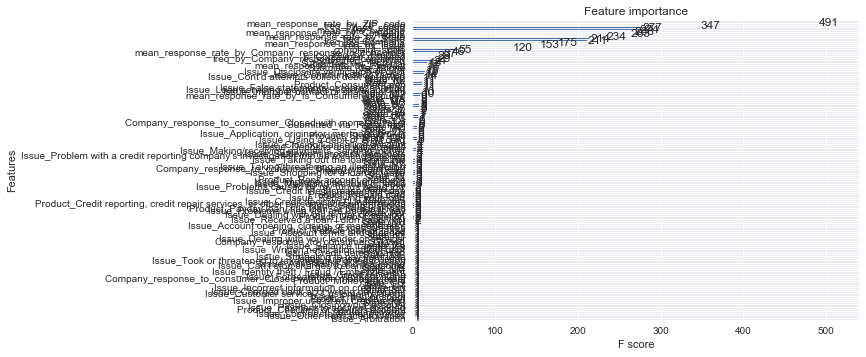

In [102]:
xgb.plot_importance(bst)
plt.show()

In [103]:
bst.get_fscore()

{'Company_response_to_consumer_Closed': 1,
 'Company_response_to_consumer_Closed with monetary relief': 6,
 'Company_response_to_consumer_Closed with non-monetary relief': 1,
 'Company_response_to_consumer_Closed without relief': 3,
 'Is_Consumer_disputed': 29,
 'Issue_Account opening, closing, or management': 1,
 'Issue_Account terms and changes': 1,
 'Issue_Advertising and marketing': 1,
 'Issue_Application, originator, mortgage broker': 5,
 'Issue_Arbitration': 1,
 'Issue_Balance transfer fee': 1,
 'Issue_Billing disputes': 2,
 "Issue_Can't stop charges to bank account": 1,
 'Issue_Charged bank acct wrong day or amt': 1,
 'Issue_Closing your account': 1,
 'Issue_Closing/Cancelling account': 4,
 'Issue_Communication tactics': 14,
 "Issue_Cont'd attempts collect debt not owed": 14,
 'Issue_Credit decision / Underwriting': 2,
 'Issue_Credit determination': 1,
 'Issue_Credit line increase/decrease': 2,
 'Issue_Credit reporting': 1,
 'Issue_Customer service / Customer relations': 1,
 'Is